# Data Loading

In [1]:
import pandas as pd
import os

data_dir = "../data"
#Read the data from data folder
user_sample = pd.read_json(os.path.join(data_dir, "user_sample.json"), lines=True)
edge_sample = pd.read_csv(os.path.join(data_dir, "edge_sample.csv"))
label_sample = pd.read_csv(os.path.join(data_dir, "label_sample.csv"))


# Centrality Analysis for HGNN Feature

In [2]:
import networkx as nx
G = nx.Graph()  # Create an undirected graph


for index, row in edge_sample.iterrows():
    if row['relation'] == 'following':
        G.add_edge(row['source_id'], row['target_id']) # Add following relationships into the graph
    

In [3]:
label = {}
for index, row in label_sample.iterrows():
    label[row['id']] = row['label'] # Transform the label of users into dict

In [4]:
# Compute centrality measures
degree_centrality = nx.degree_centrality(G)  # Degree Centrality
betweenness_centrality = nx.betweenness_centrality(G)  # Betweenness Centrality
closeness_centrality = nx.closeness_centrality(G)  # Closeness Centrality

# Hypergraph Construction

In [5]:
import easygraph as eg

/Users/boen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
#select the following relationships to build the hypergraph
following_edges = edge_sample[edge_sample['relation'] == 'following']
following_edges = following_edges.drop_duplicates()

In [8]:
#group the followers of each users
grouped_edges = following_edges.groupby('source_id')['target_id'].apply(tuple).to_dict()


In [9]:
source_ids = list(set(list(following_edges['source_id'])))
#Build the hypergraph according to co-following relationships
hyperedges = list(grouped_edges[target_id] for target_id in source_ids)


In [10]:
hyperedges

[('u2999992556',
  'u20571756',
  'u14986849',
  'u381289719',
  'u50343115',
  'u476582730',
  'u44196397',
  'u162293874',
  'u927837253',
  'u15143478',
  'u747212842470891520',
  'u1720046887',
  'u1463354832',
  'u22385548'),
 ('u22050529', 'u25427470', 'u254719698'),
 ('u1338939176356556800',),
 ('u254719698', 'u299650387', 'u44196397', 'u30354991'),
 ('u15143478', 'u3697013177', 'u44196397'),
 ('u357606935', 'u44196397'),
 ('u15143478',),
 ('u1210956763618394113',),
 ('u110441210',
  'u449462207',
  'u61853389',
  'u36116203',
  'u21114659',
  'u37563',
  'u1471035349',
  'u8724862'),
 ('u44196397',),
 ('u30354991', 'u357606935'),
 ('u44196397',
  'u20571756',
  'u17393790',
  'u474154291',
  'u22050529',
  'u8724862',
  'u36116203'),
 ('u44196397',),
 ('u2924521080', 'u18837791', 'u44196397'),
 ('u1720046887', 'u747212842470891520', 'u44196397'),
 ('u2344530218', 'u879456634413740032'),
 ('u98047213', 'u767892066'),
 ('u30354991', 'u357606935'),
 ('u21114659', 'u299650387', 'u6

# Integrate the node features, node labels
As image and text data is too large to load and needs computing power for embedding, this code only includes the feature of social network analysis and public metrics in twitter.

In [11]:
import torch
node_to_index = {}
node_labels = []
node_feats = []
for index, row in user_sample.iterrows():
    node_to_index[row['id']] = index
    id = row['id']
    if label[id] == 'human':
        node_labels.append(0)
    else:
        node_labels.append(1)
    try:
        node_feats.append([degree_centrality[id], betweenness_centrality[id], closeness_centrality[id], row['public_metrics']['followers_count'], row['public_metrics']['tweet_count']])
    except:
        node_feats.append([0,0,0, row['public_metrics']['followers_count'], row['public_metrics']['tweet_count']])

node_labels = torch.tensor(node_labels)
node_feats = torch.tensor(node_feats)

In [12]:
indexed_hyperedge_list = [tuple(node_to_index[node] for node in edge) for edge in hyperedges]
hg = eg.Hypergraph(num_v=len(node_to_index),e_list=indexed_hyperedge_list)
hg

Hypergraph(num_vertex=1000, num_hyperedge=479)

In [13]:
import numpy as np
# random seed
np.random.seed(42)


n = 1000
indices = np.arange(n)

np.random.shuffle(indices)

# tran_val_test split
train_end = int(0.3 * n)  
val_end = int(0.4 * n)   

train_mask = np.zeros(n, dtype=bool)
val_mask = np.zeros(n, dtype=bool)
test_mask = np.zeros(n, dtype=bool)

train_mask[indices[:train_end]] = True
val_mask[indices[train_end:val_end]] = True
test_mask[indices[val_end:]] = True

print(f"Train mask (70% of data): {train_mask}")
print(f"Validation mask (10% of data): {val_mask}")
print(f"Test mask (20% of data): {test_mask}")

Train mask (70% of data): [False False  True  True False  True False  True False  True  True False
 False False False False False False False False False False False  True
 False  True False False False  True  True  True False  True False False
 False False False  True False False False False  True False False False
 False  True False False False False  True  True False False False  True
  True False False  True False  True  True  True False False  True False
  True False False False  True  True  True False False  True  True False
  True False  True False  True False False False False False False False
  True  True False False False  True False False False False False  True
 False  True  True False False False False False False False  True False
  True False False False False False False False False False False False
 False False False False  True  True False  True False  True False False
 False False False False False False False False False False False  True
 False False  True False 

# Hypergraph neural network training

In [14]:
X = node_feats
y = node_labels
num_classes = 2
input_feature_dim = X.shape[1]
hidden_dim = 128
dataset = {}
dataset["structure"] = hg
dataset["features"] = X
dataset["labels"] = y
dataset["train_mask"] = train_mask
dataset["val_mask"] = val_mask
dataset["test_mask"] = test_mask
dataset["num_classes"] = num_classes


In [15]:
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
model = eg.HGNN(in_channels = input_feature_dim, hid_channels = hidden_dim,
                     num_classes = num_classes)

def train(
    data: dict,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,):

    features, structure = data["features"], data["structure"]
    train_mask, labels = data["train_mask"], data["labels"]
    optimizer.zero_grad()
    outputs = model(features, structure)

    

    loss = criterion(outputs[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def valid(model: nn.Module, data: dict):
    features, structure = data["features"], data["structure"]
    val_mask, labels = data["val_mask"], data["labels"]
    model.eval()
    outputs = model(features, structure).argmax(dim=1)
    correct = (outputs[val_mask] == labels[val_mask]).sum()
    acc = int(correct) / len(val_mask)
    return acc

@torch.no_grad()
def test(model: nn.Module, data: dict):
    features, structure = data["features"], data["structure"]
    val_mask, labels = data["test_mask"], data["labels"]
    outputs = model(features, structure).argmax(dim=1)
    correct = (outputs[val_mask] == labels[val_mask]).sum()
    acc = int(correct) / len(val_mask)

    pred_probs = torch.softmax(model(features, structure), dim=1)
    # Get the label of test data
    y_true = y[test_mask].cpu().numpy()
    # Get the probability of prediction for test dataset
    y_scores = pred_probs[test_mask].cpu().numpy()
    auc = roc_auc_score(y_true, y_scores[:, 1]) # 0:human, 1:bot

    return acc,auc

epoch: 0, valid accuracy : 0.087, loss : 134.70660400390625
epoch: 10, valid accuracy : 0.087, loss : 3.3184585571289062
epoch: 20, valid accuracy : 0.087, loss : 3.408468008041382
epoch: 30, valid accuracy : 0.087, loss : 2.7559850215911865
epoch: 40, valid accuracy : 0.087, loss : 1.8002780675888062
epoch: 50, valid accuracy : 0.087, loss : 0.7321823835372925
epoch: 60, valid accuracy : 0.087, loss : 0.5415000319480896
epoch: 70, valid accuracy : 0.087, loss : 0.5332143902778625
epoch: 80, valid accuracy : 0.087, loss : 0.5313021540641785
epoch: 90, valid accuracy : 0.087, loss : 0.5282299518585205
epoch: 100, valid accuracy : 0.087, loss : 0.5279333591461182
epoch: 110, valid accuracy : 0.087, loss : 0.5277115106582642
epoch: 120, valid accuracy : 0.087, loss : 0.5275471210479736
epoch: 130, valid accuracy : 0.087, loss : 0.527426540851593
epoch: 140, valid accuracy : 0.087, loss : 0.5273392200469971
epoch: 150, valid accuracy : 0.087, loss : 0.5272767543792725
epoch: 160, valid acc

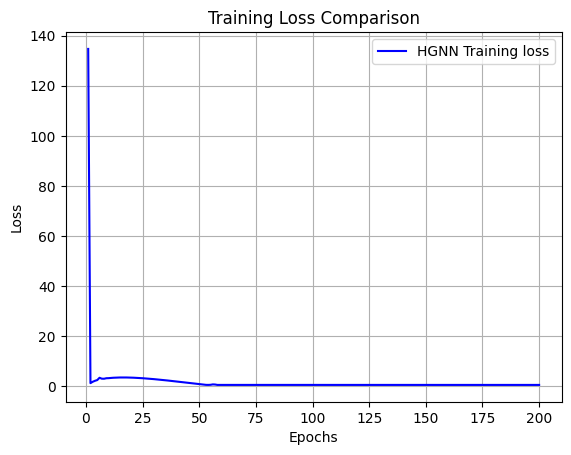

In [25]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os

# Ensure visualizations directory exists
visualizations_dir = "../visualizations"
os.makedirs(visualizations_dir, exist_ok=True)

def draw_loss_curve(loss1, save_path="Prediction_loss_pic.png"):
    plt.clf()
    epochs = range(1, len(loss1) + 1)
    plt.plot(epochs, loss1, 'b', label='HGNN Training loss')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Save the plot to the visualizations folder
    plt.savefig(os.path.join(visualizations_dir, save_path))
    plt.show()

# Training setup
loss_lst = []
epoch = 200
lr = 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.train()

# Training loop
for i in range(epoch):
    loss = train(data=dataset, model=model, optimizer=optimizer, criterion=loss_fn)
    loss_lst.append(loss.detach().numpy())
    val_acc = valid(model=model, data=dataset)
    if i % 10 == 0:
        print(f"epoch: {i}, valid accuracy : {val_acc}, loss : {loss}")

print("Training finish!")

# Test results
test_acc, test_auc = test(model=model, data=dataset)
print("test accuracy:", test_acc)
print("test rocauc:", test_auc)

# Draw and save the loss curve
draw_loss_curve(loss_lst)


### Analysis of Model Performance

- **Test Accuracy**: 0.5
- **Test ROC AUC Score**: 0.61  

The model's performance shows a moderate result with an accuracy of 0.5, which indicates that it is somewhat effective, but there is significant room for improvement. The ROC AUC score of 0.61, however, suggests that the model is able to differentiate between classes reasonably well, as a score above 0.5 indicates it performs better than random guessing.

#### Possible Reasons for Current Performance:
- **Limited Features**: The features used in the model may not be comprehensive enough to fully capture the underlying patterns in the data, which could be limiting its performance. Adding more diverse and relevant features might improve the results.

#### Innovations and Approach:
- This method represents an innovative approach by utilizing Hypergraph Neural Networks (HGNNs) to capture group interactions for bot detection. Traditional methods often fail to effectively model such interactions, but this approach offers a promising way to address this gap.

### Future Work:
- **Expanding Relationships**: Future work could include incorporating additional relationships, not only co-following but also:
  - Co-retweeting
  - Co-hashtag usage
  - Co-liking
  
By adding more types of interactions, the model could capture a broader range of group behaviors, which may improve its ability to detect bots more accurately.
